In [1]:
#import lib
#lib.load_styles_and_macros()

ModuleNotFoundError: No module named 'lib'

<div class="header">
    <div class="title">
    <h1>Programming Exercise 1</h1>
    </div>
    <div class="authors">
        Prof. Dr. Julia Kowalski<br/>
        Ullika Scholz <br/>
        Ingo Steldermann <br/>
    </div>
    <div class="logo">
        <img src="https://www.mbd.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaabkcpost">
        This content is best viewed in JupyterLab.
    </div>
</div>

# Programming Exercise 3

If there are any questions, feel free to ask (steldermann@mbd.rwth-aachen.de)

## Imports

In [3]:
import numpy as np
from scipy.optimize import fminbound, minimize_scalar
from scipy.integrate import quad, dblquad, fixed_quad, quad_vec
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image
import copy
import time

## Remark 1:

In this exercise in particular, there are many possible ways how to structure your code into different parts and functions. Therefore feel free to modify or completely change the given template if it does not suite your own style. 

## Remark 2:

The complete notebook might take a significant time to execute. On the RWTHjupyter, the reference solutions runs approx. 10 minutes to execute the full notebook.
In case your code needs significantly longer, consider using the RWTHjupyter server. Also, **please run your full notebook before the presentation starts**, so that we don't need to wait until everything is computed.

# Part 1: Finite Volume Method for Different Flux Functions

## Data Class

### Inputs:

The class *Data* contains the information that define our mathematica problem, namely information about:
- the geometry:
    - *a*: position of first node
    - *b*: position of last node
    - *N*: number of nodes (equidistant grid)
- parameters:
    - *cfl*: cfl condition number
- the problem:
    - *eqn_type*: [*advection* | *burgers* ] specify if the advection equation or burgers equation should be solved
    - *flux_type*: [*naiv* | *lax_friedrichs* | *lax_wendroff*] specify which numerial flux function should be used in your solver
    - *init_cond*: [*smooth* | *jump*] specify which initial conditions should be used in your simulation
    
Bases on those inputs, the class also computes come derived information, namely:
- *dx*: the grid size
- *u0*: the continuous function definind your initial data, bases on *init_cond*.Note: The analytical function is defined in terms of a lambda function, which takes 1 argument (x).
- *u_ex*: the analytical solution for the specified *flux_type* and *init_cond*. Note: The analytical function is defined in terms of a lambda function, which takes 2 arguments (x,t).

### Usage:

You can instantiate this class e.g. by using the following code: \
*>> data = Data(-1, 1, 10, cfl=0.9, init_cond='smooth', eqn_type='advection', flux_type='naiv')*

If you want to access a class variable, (e.g. the gridsize dx), you can then call: \
*>> data.dx*

If you want to evaluate the analytical solution at some point (e.g. x=0.2, t=0.4), you need to call: \
*>> data.u_ex(0.2, 0.4)*

In [281]:
class Data:
    def __init__(self, a, b, N,cfl, init_cond, eqn_type, flux_type):
        self.a=a
        self.b=b
        self.N=N
        self.dx=(b-a)/(N-1)
        self.cfl=cfl
        
        assert(flux_type=='naiv' or flux_type=='lax_friedrichs' or flux_type=='lax_wendroff')
        self.flux_type=flux_type
        
        assert(init_cond=='smooth'or init_cond=='jump')
        self.init_cond=init_cond
        
        if (init_cond=='smooth'):
            self.u0 = lambda x: np.sin(2*np.pi*x/(b-a+self.dx))
        elif (init_cond=='jump'):
            self.u0 = lambda x:  1.0 * np.ceil(x+0.5)%2
            
        if (eqn_type=='advection'):
            self.eqn_type=eqn_type
            c = 2.
            self.f = lambda u: c*u
            self.df = lambda u: c
            self.u_ex = lambda x,t: self.u0(x-c*t)
        elif (eqn_type=='burgers'):
            self.eqn_type=eqn_type
            self.f = lambda u: 0.5*u**2
            self.df = lambda u: u
            if (init_cond=='smooth'):
                def u_ex(x,t):
                    xmin = fminbound(self.u0, a, b)
                    u0min = self.u0(xmin)
                    xmax = fminbound(lambda x: -self.u0(x), a, b)
                    u0max = self.u0(xmax)
                    return fminbound(lambda u: (u-self.u0(x-t*u))**2, u0min, u0max)
                self.u_ex = np.vectorize(u_ex)
            elif (init_cond=='jump'):
                u_ex = lambda x, t: (x+0.5)/t if -0.5 <= x < -0.5+t  else (1 if -0.5+t <= x < 0.5+0.5*t else 0)
                self.u_ex = np.vectorize(u_ex)
            else:
                assert(False)
        else:
            print('unknown equation type:', eqn_type, ' [advection|burgers]')
            assert(False)

## Numerical Flux Function

F returns the numerical flux function, based on the flux type (*flux_type*) defined in *data*.

In [282]:
def F(ul, ur, dx, dt, data):
    #TODO
    if (data.flux_type=='naiv'):
        return 0.5 * (data.f(ul) + data.f(ur))
    elif (data.flux_type=='lax_friedrichs'):
        return 0.5 * (data.f(ul) + data.f(ur)) - 0.5 * data.dx / dt * (ur - ul)
    elif (data.flux_type=='lax_wendroff'):
        if (data.eqn_type=='advection'):
            return 0.5 * (data.f(ul) + data.f(ur)) - 0.5 * dt/data.dx * data.df(ul)**2 * (ur - ul)
        elif (data.eqn_type=='burgers'):
            return 0.5 * (data.f(ul) + data.f(ur)) - 0.5 * dt/data.dx * 0.25 * (ur + ul)**2 * (ur - ul)
    else:
        assert(False)    

## Useful Functions

The initial condition is specified as a continous function. However, your numerical scheme requires piecewise constant data defined at every cell. Therefore you need to compute the average of the initial condition over each cell.\
**Note:** Be precide about the position of your cell interfaces. Those are located in between two adjacent nodes. The first and last cell **center** was defined as *a* and *b*.\
**Note:**: We assume a **periodic** problem. Luckily, the initial conditions are set up so that you can integrate your initial condition in a domain $x \in [a-dx\, /\, 2, b+dx\,/\,2)$.

In [9]:
def compute_u_average(data):
    #TODO
    u_average = np.zeros(data.N)
    u_average[0] = 0.5 * (data.u0(data.a-0.5*data.dx) + data.u0(data.b+0.5*data.dx))
    u_average[-1] = u_average[0]
    for i in range(data.N-2):
        u_average[i+1] = 0.5 * (data.u0(data.a+(i+0.5)*data.dx) + data.u0(data.a+(i+1.5)*data.dx))
    return u_average

The function *compute_dt(data)* should return the time step size *dt* such that the specified cfl conditin is met.

In [50]:
def compute_dt(data):
    #TODO
    if (data.eqn_type == 'advection'):
        dt = data.cfl * data.dx / data.df(data.a)
    elif (data.eqn_type == 'burgers'):
        dt = data.cfl * data.dx / np.max(np.abs(data.u0(np.linspace(data.a, data.b, data.N))))
    return dt

The function *compute_next_timestep(U, data)* compures the time step size.\
**Expected input:** current solution *U* at time t $U(t)$ and the data object *data*. \
**Expected return:** new solution at time t+dt: $U(t+dt)$. \
Use **periodic** boundary conditions. A very simple implementation can be achived by using the numpy function *np.roll* (https://numpy.org/doc/stable/reference/generated/numpy.roll.html).

In [11]:
def compute_next_timestep(U, dt, data):
    #TODO
    U_next = np.zeros(data.N)
    for i in range(data.N-1):
        U_next[i] = U[i] - dt / data.dx * (F(U[i], U[i+1], data.dx, dt, data) - F(U[i-1], U[i], data.dx, dt, data))
    U_next[-1] = U[-1] - dt / data.dx * (F(U[-1], U[0], data.dx, dt, data) - F(U[-2], U[-1], data.dx, dt, data))
    return U_next

This helper function evaluates the analytical solution *data.u_ex* at position *t* for a discrete mesh *X*. \
**Expected input:** current time *t*, data object *data* \
**Expected return:** (mesh_vector, analytical_solution_vector) \
**Note:** both vectors are of equal length

In [63]:
def get_exact_solution_at(t, data):
    #TODO
    grid = np.linspace(data.a, data.b, data.N)
    u_ex = np.zeros(data.N)
    for i in range(data.N):
        u_ex[i] = data.u_ex(grid[i], t)
    return grid, u_ex

The function *finite_volume_method* executes your FVM simulation for the problem specified in the inputs. It should complete the following tasks: \
-create your data object \
-compute your averaged initial condition \
-advance in time until *tend* is met \
**Expected input:** 
- a, b, N, cfl, init_cond, eqn_type, flux_type --> see Data class 
- *tend*: end time of your simulation 
- *supress_output*: if flag is set *True*, the number of print statements is reduced to a minimum 
**Expected return:** 
- list of solution vectors, one for each time step (include initial condition) 
- list of times, where the solutions are computed 
- data object

In [51]:
def finite_volume_method(a, b, N, tend, cfl, init_cond, eqn_type, flux_type, suppress_output=False):
    #TODO
    # initialize
    data = Data(a, b, N, cfl, init_cond, eqn_type, flux_type)
    U = compute_u_average(data)
    U_list = [U]
    t = 0
    T_list = [t]
    dt = compute_dt(data)
    # main loop
    while t < tend:
        t = t + dt
        U = compute_next_timestep(U, dt, data)
        U_list.append(U)
        T_list.append(t)
    return U_list, T_list, data

# Simulations

Let's try out our code on different test cases:

In [283]:
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='naiv')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_friedrichs')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_wendroff')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='naiv')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_friedrichs')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_wendroff')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='naiv')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_friedrichs')
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_wendroff')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='naiv')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_friedrichs')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_wendroff')
## Plot Solution

## Plot Solution

The following code will plot the numerical and analytical solution obtained above. 

In [284]:
%%capture
fig, ax = plt.subplots()
X_ex, U_ex = get_exact_solution_at(0.0, data)
X = np.linspace(data.a, data.b, data.N)
U_plot, = ax.plot(X, U_list[0])
U_plot_ex, = ax.plot(X_ex, U_ex)

def animate(i):
    X_ex, U_ex = get_exact_solution_at(T_list[i], data)
    ax.set_title('IC: ' + data.init_cond + '   eqn_type:' + data.eqn_type + '   method: ' + data.flux_type + '   time: ' + str(np.round(T_list[i], 3)))
    U_plot.set_ydata(U_list[i]) 
    ax.set_ylim(np.min(U_list[0])-0.1, np.max(U_list[0])+0.1)
    U_plot_ex.set_ydata(U_ex)
    U_plot.set_drawstyle('steps-mid')
    U_plot.set_marker('.')
    return U_plot,
anim = animation.FuncAnimation(
    fig, animate, frames=len(U_list), interval=80, blit=True)

In [286]:
HTML(anim.to_jshtml())

# Part 2: Convergence Analysis

## Useful Functions

We need to numerically evaluate the integral over one space-time element from $[x_{i-1/2}, x_{i+1/2}]\times[t_i, t_{i+1}]$. As a recommandation, you may use the function
*fixed_quad(lambda x: f(x), x0, x1, n=5* (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.fixed_quad.html), which is a fifth order numerical integration scheme for a one dimensional function. 
In order to obtain a two dimensional integration over our space time element, you need to integrate slices (in time or space) of your space time element. The position of those slices correspond to the 'outer' 1D quadrature.
In case you do not want to use the *fixed_quad* function for your outer (or inner) quadrature, you can also implement it yourself. See (https://en.wikipedia.org/wiki/Gaussian_quadrature) for a quick reference. 

**Expected input:** 
- du: Integrand of the L1 norm. Note: define du as a function with arguments (x,t)
- t0,t1,x0,x1: borders of the space-time-cell
**Expected return:** L1-error of space-time cell

In [229]:
def dblquad_5th_order(du, t0, t1, x0, x1):
    #TODO
    return fixed_quad(lambda t: fixed_quad(lambda x: du(t, x), x0, x1, n=5)[0], t0, t1, n=5)[0]

To make things easier, let's split our L1_error function into two parts. The function *L1_error* should return the error for the solution under consideration. The function *L1_error_space_time_cell* takes our numerical solution for one space-time cell $[x_0, x_1]\times[t_0, t_1]$ and computes its L1-error. 
The flag *projected* indicates if the analytical solution should be projected onto its cell-wise constant approximation.

In [230]:
def L1_error_timestep(U, x0, x1, t0, t1, data, projected=False):
    #TODO
    err = 0
    if (projected):
        for i in range(data.N):
            # u_ex = 0.25 * (data.u_ex(data.dx * (i-0.5), t0) + data.u_ex(data.dx * (i+0.5), t0) + data.u_ex(data.dx * (i-0.5), t1) + data.u_ex(data.dx * (i+0.5), t1))
            temp = data.u_ex(data.a + data.dx * i, 0.5*(t0+t1))
            err += np.abs(U[i] - temp) * data.dx * (t1 - t0)
    else:
        for i in range(data.N):
            du = lambda t, x: np.abs(U[i] - data.u_ex(x, t))
            err += dblquad_5th_order(du, t0, t1, data.a + data.dx * (i-0.5), data.a + data.dx * (i+0.5))
    return err

In [231]:
def L1_error(U_list, T_list, data, projected=False):
    #TODO
    err = 0
    dt = T_list[1] - T_list[0]
    for i in range(len(U_list)-1):
        err += L1_error_timestep(U_list[i], data.a, data.b, T_list[i]-0.5*dt, T_list[i]+0.5*dt, data, projected)
    return err

### Testing

In [297]:
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=50, tend=0.3, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_wendroff')
print(L1_error(U_list, T_list, data))
print(L1_error(U_list, T_list, data, projected=True))

0.013832713913415635
0.00327461960065192


## Plotting Tools

This function generates your convergence plots. \
**Expected inputs:** 
- *meshsizes*: list of the different meshsizes under consideration, e.g. [20, 40, 80, 160, 320]
- *l_errors*: list of L1-errors. Must have the same size as *meshsizes*
- *l_errors_proj*: list of projected L1-errors. Must have the same size as *meshsizes*
- *l_data*: list of data objects. Must have the same size as *meshsizes*


In [197]:
def convergence_plots(meshsizes, l_errors, l_errors_proj, l_data):
    fig, ax = plt.subplots(1,len(l_errors))
    def generate_plot_from_axis(ax, meshsizes, errors, errors_projected, data):
        def minmax(l):
            l_min = min(l)
            l_max = max(l)
            return [l_min, l_max]
        meshsizes = np.array(meshsizes)
        ax.loglog(meshsizes, errors, 'xg')
        ax.loglog(meshsizes, errors_projected, 'xb')
        ax.loglog(minmax(meshsizes), errors[0]*min(meshsizes**0.5)/minmax(meshsizes**0.5), '--g', alpha=0.5, label="0.5 order")
        ax.loglog(minmax(meshsizes), errors[0]*min(meshsizes)/minmax(meshsizes), '-g', alpha=0.5, label="1 order ")
        ax.loglog(minmax(meshsizes), errors[0]*min(meshsizes**2)/minmax(meshsizes**2), '--g', alpha=0.5, label="2 order")
        ax.loglog(minmax(meshsizes), errors_projected[0]*min(meshsizes**0.5)/minmax(meshsizes**0.5), '--b', alpha=0.5, label="0.5 order (projected)")
        ax.loglog(minmax(meshsizes), errors_projected[0]*min(meshsizes)/minmax(meshsizes), '-b', alpha=0.5, label="1 order (projected)")
        ax.loglog(minmax(meshsizes), errors_projected[0]*min(meshsizes**2)/minmax(meshsizes**2), '--b', alpha=0.5, label="2 order (projected)")
        ax.set_xlabel('number of nodes')
        ax.set_ylabel('L1 error')
        ax.set_title('L1-error with \n IC: ' + data.init_cond + '\n eqn_type:' + data.eqn_type + '\n method: ' + data.flux_type, loc='left')
        ax.legend()
        ax.axis('equal')
    fig.set_figwidth(20)
    fig.set_figheight(8)
    #plt.tight_layout()
    if len(l_errors)==1:
        generate_plot_from_axis(ax, meshsizes, l_errors, l_errors_proj, l_data)
    else:
        for i in range(len(l_errors)):
            generate_plot_from_axis(ax[i], meshsizes, l_errors[i], l_errors_proj[i], l_data[i])


## Error Analysis

### Compute error for advection equation with smooth initial conditions

In [211]:
meshsizes = [20* 2**(i) for i in range(5)]
dh = [2**4 / 2**(i) for i in range(5)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
l_errors_naiv = []
l_errors_proj_naiv = []
data = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=1.0, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='naiv')
    l_errors_naiv.append(L1_error(U_list, T_list, data))
    l_errors_proj_naiv.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_naiv)
l_errors_proj.append(l_errors_proj_naiv)

#lax_friedrichs
l_errors_lax_friedrichs = []
l_errors_proj_lax_friedrichs = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=1.0, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_friedrichs')
    l_errors_lax_friedrichs.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_friedrichs.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_friedrichs)
l_errors_proj.append(l_errors_proj_lax_friedrichs)
    
#lax_wendroff
l_errors_lax_wendroff = []
l_errors_proj_lax_wendroff = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=1.0, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_wendroff')
    l_errors_lax_wendroff.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_wendroff.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_wendroff)
l_errors_proj.append(l_errors_proj_lax_wendroff)


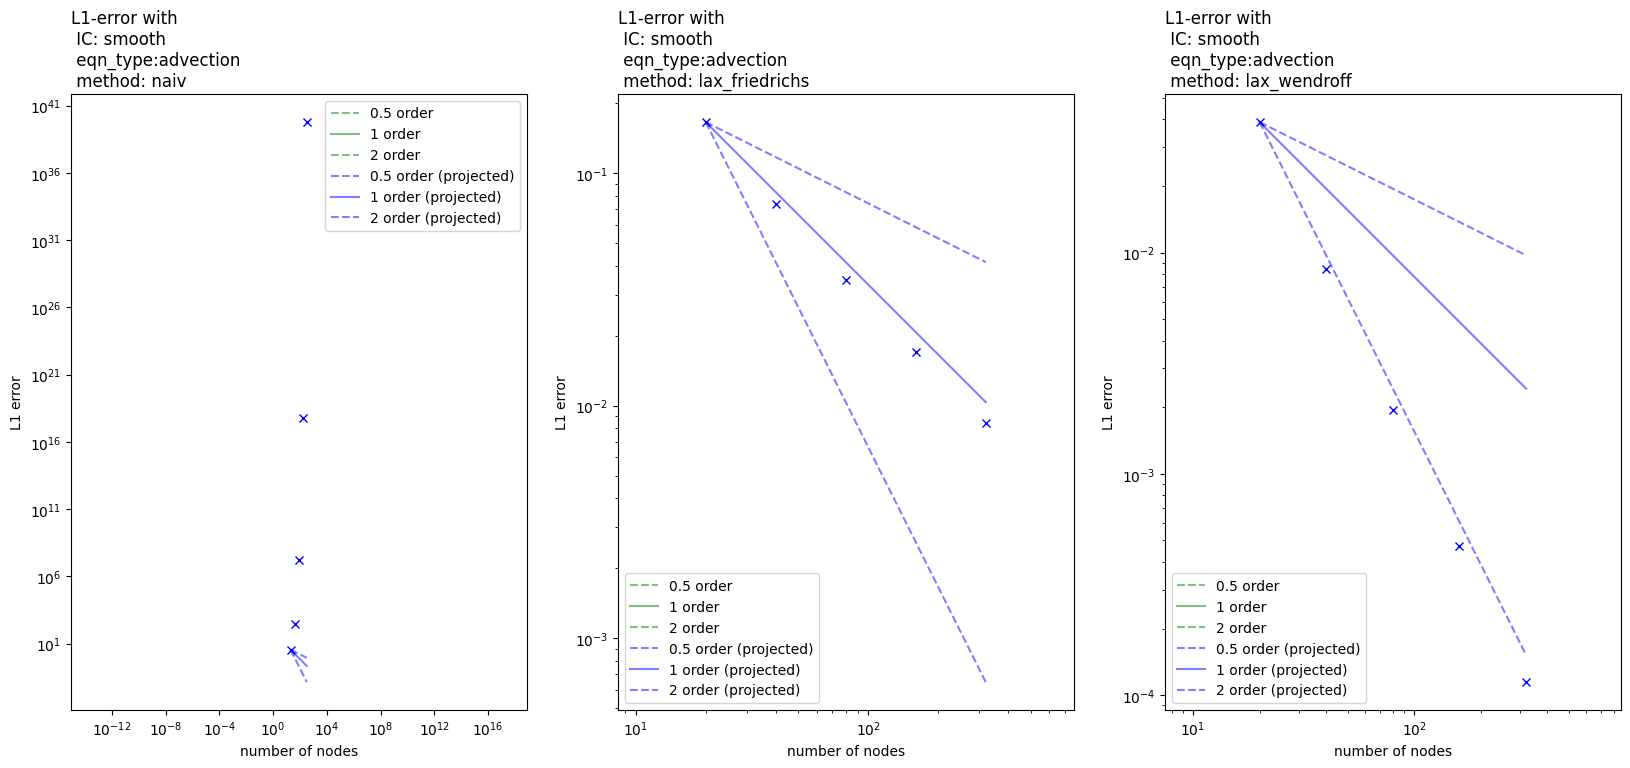

In [212]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

### Compute error for advection equation with jump initial conditions

In [200]:
meshsizes = [20* 2**(i) for i in range(5)]
dh = [2**4 / 2**(i) for i in range(5)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
l_errors_naiv = []
l_errors_proj_naiv = []
data = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=1.0, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='naiv')
    l_errors_naiv.append(L1_error(U_list, T_list, data))
    l_errors_proj_naiv.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_naiv)
l_errors_proj.append(l_errors_proj_naiv)

#lax_friedrichs
l_errors_lax_friedrichs = []
l_errors_proj_lax_friedrichs = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=1.0, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_friedrichs')
    l_errors_lax_friedrichs.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_friedrichs.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_friedrichs)
l_errors_proj.append(l_errors_proj_lax_friedrichs)
    
#lax_wendroff
l_errors_lax_wendroff = []
l_errors_proj_lax_wendroff = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=1.0, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_wendroff')
    l_errors_lax_wendroff.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_wendroff.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_wendroff)
l_errors_proj.append(l_errors_proj_lax_wendroff)


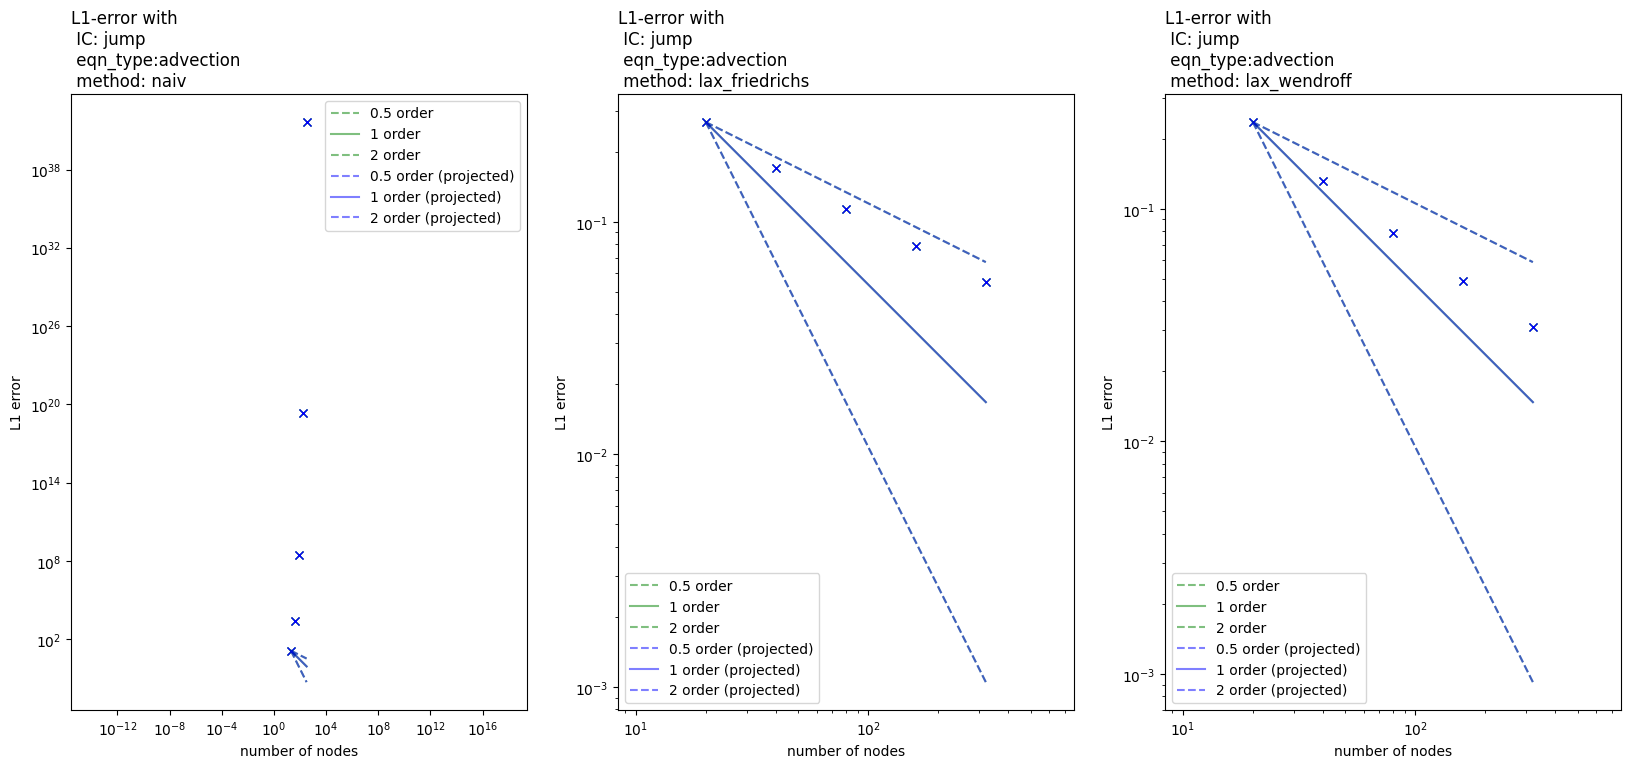

In [201]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

### Compute error for Burgers equation with smooth initial conditions 

In [301]:
meshsizes = [20* 2**(i) for i in range(5)]
dh = [2**4 / 2**(i) for i in range(5)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
l_errors_naiv = []
l_errors_proj_naiv = []
data = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=0.3, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='naiv')
    l_errors_naiv.append(L1_error(U_list, T_list, data))
    l_errors_proj_naiv.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_naiv)
l_errors_proj.append(l_errors_proj_naiv)

#lax_friedrichs
l_errors_lax_friedrichs = []
l_errors_proj_lax_friedrichs = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=0.3, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_friedrichs')
    l_errors_lax_friedrichs.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_friedrichs.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_friedrichs)
l_errors_proj.append(l_errors_proj_lax_friedrichs)
    
#lax_wendroff
l_errors_lax_wendroff = []
l_errors_proj_lax_wendroff = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=0.3, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_wendroff')
    l_errors_lax_wendroff.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_wendroff.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_wendroff)
l_errors_proj.append(l_errors_proj_lax_wendroff)


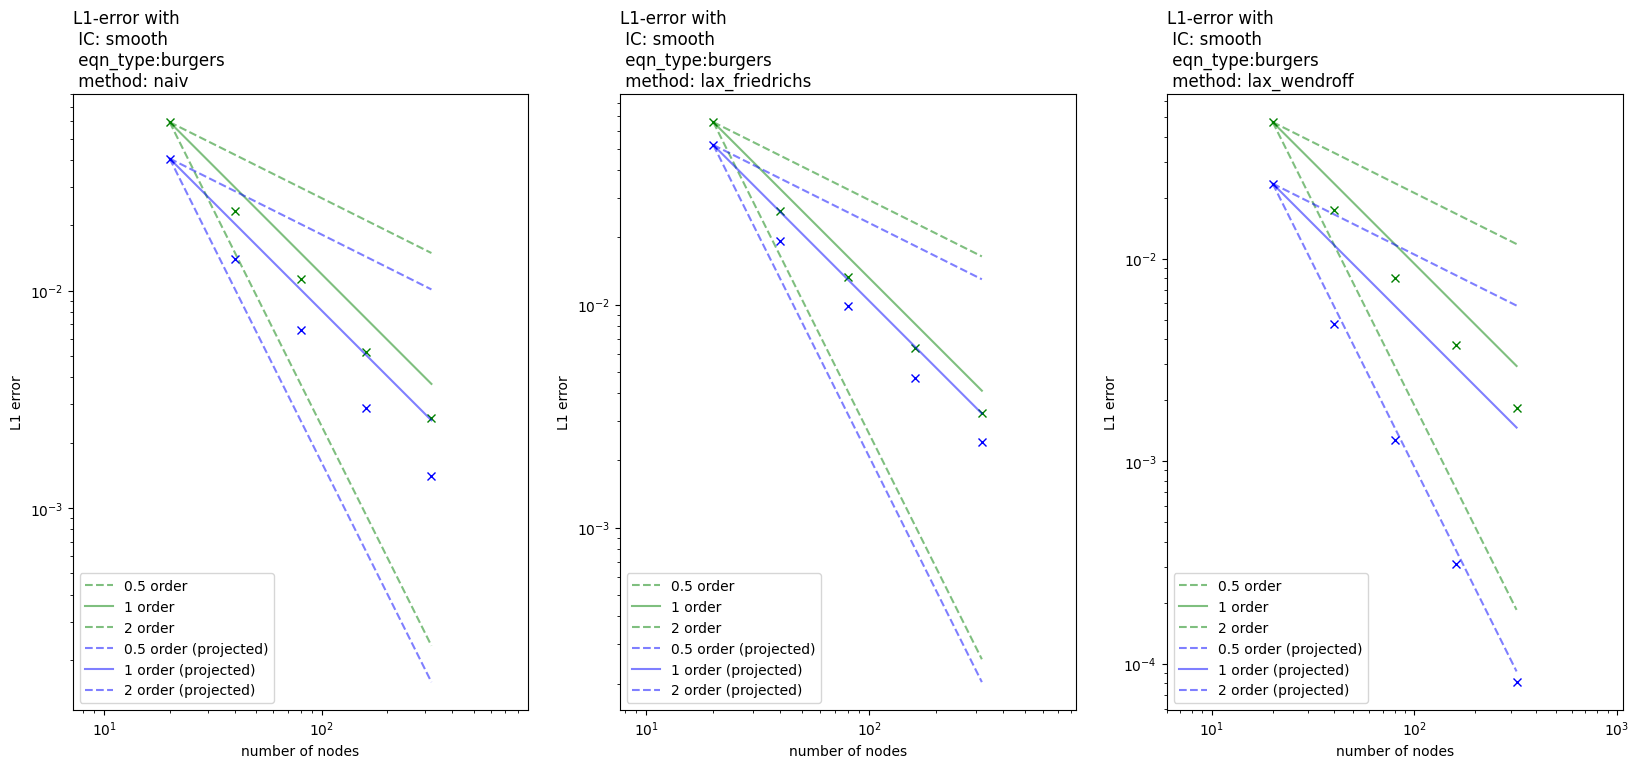

In [302]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

### Compute error for Burgers equation with jump initial conditions 

In [303]:
meshsizes = [20* 2**(i) for i in range(5)]
dh = [2**4 / 2**(i) for i in range(5)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
l_errors_naiv = []
l_errors_proj_naiv = []
data = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=0.9, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='naiv')
    l_errors_naiv.append(L1_error(U_list, T_list, data))
    l_errors_proj_naiv.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_naiv)
l_errors_proj.append(l_errors_proj_naiv)

#lax_friedrichs
l_errors_lax_friedrichs = []
l_errors_proj_lax_friedrichs = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=0.9, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_friedrichs')
    l_errors_lax_friedrichs.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_friedrichs.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_friedrichs)
l_errors_proj.append(l_errors_proj_lax_friedrichs)
    
#lax_wendroff
l_errors_lax_wendroff = []
l_errors_proj_lax_wendroff = []
for N in meshsizes:
    U_list, T_list, data = finite_volume_method(a=-1, b=1, N=N, tend=0.9, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_wendroff')
    l_errors_lax_wendroff.append(L1_error(U_list, T_list, data))
    l_errors_proj_lax_wendroff.append(L1_error(U_list, T_list, data, projected=True))
l_data.append(data)
l_errors.append(l_errors_lax_wendroff)
l_errors_proj.append(l_errors_proj_lax_wendroff)


C:\Users\Jiayin Hu\AppData\Local\Temp\ipykernel_9088\3393236763.py:28: RuntimeWarning: overflow encountered in scalar power
  self.f = lambda u: 0.5*u**2
C:\Users\Jiayin Hu\AppData\Local\Temp\ipykernel_9088\959152307.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  U_next[i] = U[i] - dt / data.dx * (F(U[i], U[i+1], data.dx, dt, data) - F(U[i-1], U[i], data.dx, dt, data))


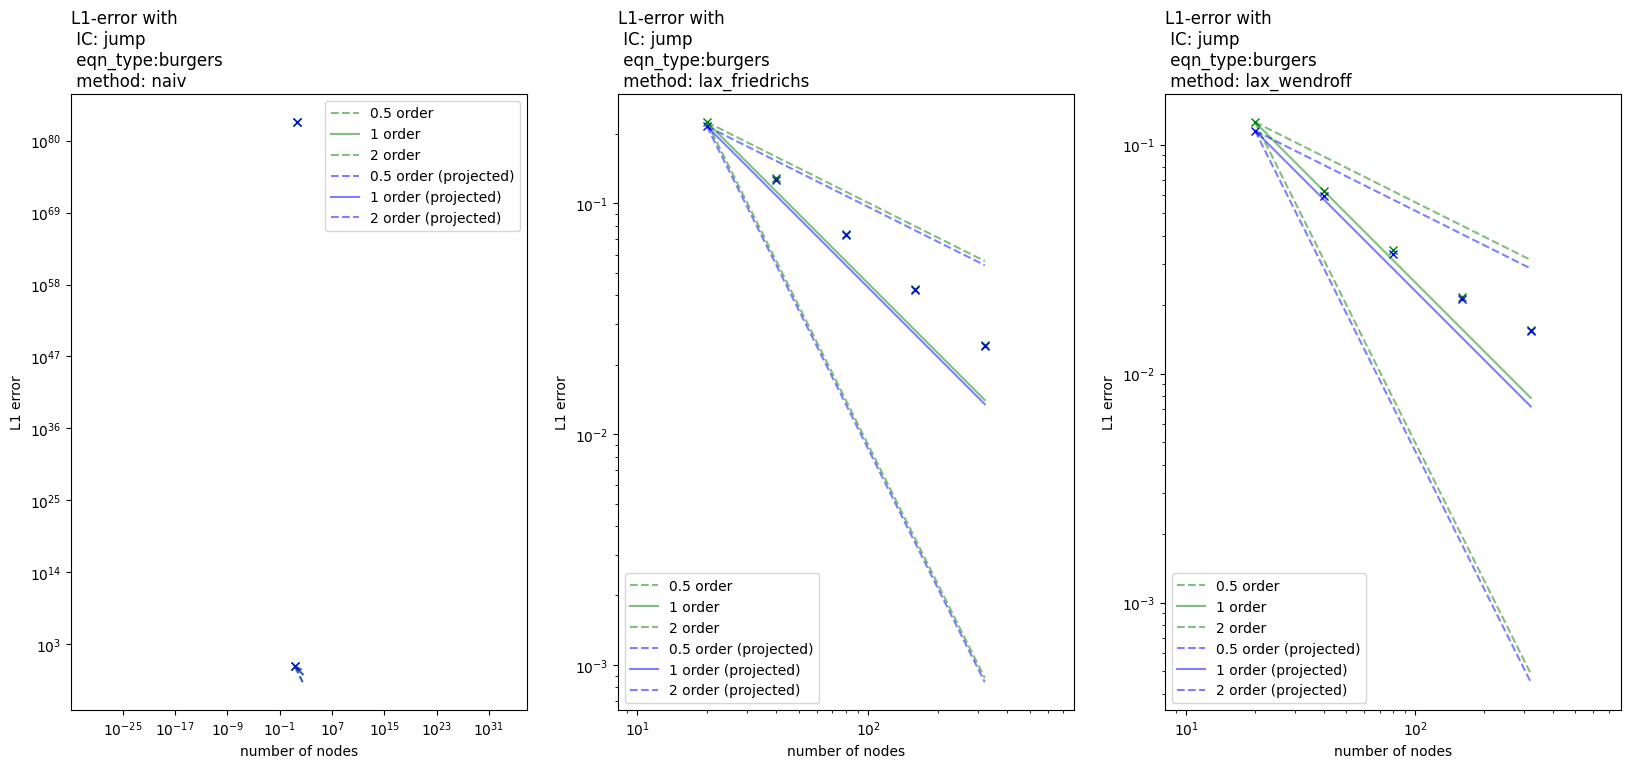

In [304]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

# Part 3: HLL Scheme for Euler Equations

## Remark:

In this exercise in particular, there are many possible ways how to structure your code into different parts and functions. Feel free to modify or completely change the given template if it does not suite your own style. 

## Problem related functions

Helper function to convert from primitive variables ($\rho, u, p$) to conservative variables ($\rho, \rho u, E$).

In [ ]:
def p2c(U):
    #TODO
    return #TODO

def c2p(U):
    #TODO
    return #TODO

It is convenient to have functions for the sound speed and the eigenvalue computation, since those functions are useful in many different numerical schemes.

In [ ]:
def soundspeed(U):
    #TODO
    return #TODO

def compute_evals(U):
    #TODO
    return #TODO

Definition for the flux function of Euler's equations.

In [ ]:
def f(U):
    #TODO
    return #TODO

# Numerics

## HLL scheme

The following function computes: $ \mathbf{u}^{n+1}_i = \mathbf{u}^n_i + \frac{\Delta t}{\Delta x}(\, \mathbf{F}(\mathbf{u}^n_{i-1}, \mathbf{u}^n_{i}) - \mathbf{F}(\mathbf{u}^n_{i}, \mathbf{u}^n_{i+1}))$ for one time step.

In order to implement the bounday conditions (zero-order extrapolation), you may want to use the function numpy.pad (https://numpy.org/doc/stable/reference/generated/numpy.pad.html) with mode='edge'.

**Inputs**:
- *U*: current solution
- *cfl*: your cfl-goal
- *dx* or grid *X*: information regarding the physical domain
- (optinoal) *t*, *Tend*: time step information in order to correct dt if t > Tend
**Returns**:
- *Unew*: solution at time step $t+dt$
- *dt*: time step 

In [ ]:
def hll_step(Un, cfl, dx, t, Tend):
    #TODO
    return #TODO

## FVM Solver

**Make sure that your simulation ends on the time you specified!** (in this exercise: $t \in [0.0, 0.25]$). So it might be necessary to adapt the time step size $dt$ for the last time step.

In [ ]:
def solver(X, U0, Tend=0.25, cfl=0.9):
    #TODO
    return U_list, T_list

## Initial conditions

Set your initial conditions. Recall that we need to compute cell-wise constant approximations of your initial data. 
**Inputs:**
- *N*: number of cells in our domain 
- *IC_func*: function specifying our initial conditions 
**Returns:**
- *X*, *U0*: computational grid *X*, piecewise constant intial data *U0*

In [ ]:
def inital_conditions(N, IC_func):
    #TODO
    return X, U0

# Test Cases 

## Setup

Here, we specify your initial conditions (e.g. with lambda functions)

In [ ]:
IC1_p = lambda x: #TODO
IC2_p = lambda x: #TODO

In [ ]:
X, U0 = inital_conditions(200, IC1_p)
#X, U0 = inital_conditions(200, IC2_p)

## Run simulations

In [ ]:
U, T = solver(X, U0, Tend=0.2, cfl=0.9)

# Visualization

It is very common to plot the fields $(\rho, u, p)$ for Euler's equation, even if the simulation was performued using conservative variables. In this visualization, we want to plot the fields $(\rho, u, p, E)$.

In order to use the animation template belove, your data needs to be structured as follows: 
- U: array of shape [num_time_steps, num_fields, num_nodes], where num_fields=4, since we want to plot $(\rho, u, p, E)$ 
- T: array of shape [num_time_steps], containing the discrete time steps

*U_min* and *U_max* are used to set the y-limits in the following animation

In [ ]:
U_max = np.array([np.max(np.array(U)[:,0,:]), np.max(np.array(U)[:,1,:]), np.max(np.array(U)[:,2,:]), np.max(np.array(U)[:,3,:])])
U_min = np.array([np.min(np.array(U)[:,0,:]), np.min(np.array(U)[:,1,:]), np.min(np.array(U)[:,2,:]), np.min(np.array(U)[:,3,:])])

In [ ]:
%%capture
fig, ax = plt.subplots(2,2)
fig.set_dpi(150)
artists = []
artists.append(ax[0,0].plot(X, U[0][0,:])[0])
artists.append(ax[0,1].plot(X, U[0][1,:])[0])
artists.append(ax[1,0].plot(X, U[0][2,:])[0])
artists.append(ax[1,1].plot(X, U[0][3,:])[0])
ax[0, 0].legend(['rho'])
ax[0, 1].legend(['v'])
ax[1, 0].legend(['p'])
ax[1, 1].legend(['E'])
ax[0, 0].set_xlim(-0.5, 0.5)
ax[0, 1].set_xlim(-0.5, 0.5)
ax[1, 0].set_xlim(-0.5, 0.5)
ax[1, 1].set_xlim(-0.5, 0.5)
ax[0,0].set_title('HLL: time: ' + str(np.round(T[0],3))) 

def animate(i):
    artists[0].set_ydata(U[i][0,:])
    artists[1].set_ydata(U[i][1,:])
    artists[2].set_ydata(U[i][2,:])
    artists[3].set_ydata(U[i][3,:])
    ax[0,0].set_title('HLL: time: ' + str(np.round(T[i],3))) 
    ax[0,0].set_ylim(U_min[0]-0.1, U_max[0]+0.1)
    ax[0,1].set_ylim(U_min[1]-0.1, U_max[1]+0.1)
    ax[1,0].set_ylim(U_min[2]-0.1, U_max[2]+0.1)
    ax[1,1].set_ylim(U_min[3]-0.1, U_max[3]+0.1)
    return artists
anim = animation.FuncAnimation(
    fig, animate, frames=len(U), interval=80, blit=True)

In [ ]:
HTML(anim.to_jshtml())

## Reference solution

In case you want to verify your code, here are some simulation results from my machine run with N=200. The last frame in both data sets correpsonds to T=0.2.

In [ ]:
X = np.linspace(-1, 1, 200)

### TC 1

In [ ]:
with open('solution200-TC1.npy', 'rb') as f:
    U_sol = np.load(f)
    T_sol = np.load(f)

In [ ]:
fig, ax = plt.subplots(2,2)
fig.set_dpi(150)
ax[0,0].set_title('reference solution at time for TC 1: ' + str(T_sol[-1]))
ax[0, 0].plot(X, np.transpose(U_sol[-1][0]))
ax[0, 1].plot(X, np.transpose(U_sol[-1][1]))
ax[1, 0].plot(X, np.transpose(U_sol[-1][2]))
ax[1, 1].plot(X, np.transpose(U_sol[-1][3]))
ax[0, 0].legend(['rho'])
ax[0, 1].legend(['v'])
ax[1, 0].legend(['p'])
ax[1, 1].legend(['E'])
ax[0, 0].set_xlim(-0.5, 0.5)
ax[0, 1].set_xlim(-0.5, 0.5)
ax[1, 0].set_xlim(-0.5, 0.5)
ax[1, 1].set_xlim(-0.5, 0.5)
plt.show()

### TC 2

In [ ]:
with open('solution200-TC2.npy', 'rb') as f:
    U_sol2 = np.load(f)
    T_sol2 = np.load(f)

In [ ]:
fig, ax = plt.subplots(2,2)
fig.set_dpi(150)
ax[0,0].set_title('reference solution at time for TC 2: ' + str(T_sol2[-1]))
ax[0, 0].plot(X, np.transpose(U_sol2[-1][0]))
ax[0, 1].plot(X, np.transpose(U_sol2[-1][1]))
ax[1, 0].plot(X, np.transpose(U_sol2[-1][2]))
ax[1, 1].plot(X, np.transpose(U_sol2[-1][3]))
ax[0, 0].legend(['rho'])
ax[0, 1].legend(['v'])
ax[1, 0].legend(['p'])
ax[1, 1].legend(['E'])
ax[0, 0].set_xlim(-0.5, 0.5)
ax[0, 1].set_xlim(-0.5, 0.5)
ax[1, 0].set_xlim(-0.5, 0.5)
ax[1, 1].set_xlim(-0.5, 0.5)
plt.show()